<a href="https://colab.research.google.com/github/briceshun/sm_contagion/blob/SIR/ContagionModels_FTX_SIR_I1_inf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install `libncurses`

In [80]:
!apt-get install libncurses5

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
# Restart runtime after install
import os
os.kill(os.getpid(), 9)

# Install Required Packages

In [4]:
!pip install -q tellurium==2.2.8

In [5]:
!pip install import-ipynb seaborn lmfit

---
# Import Packages

In [6]:
# Google Drive
from google.colab import drive
drive.mount("mnt", force_remount=True)

# Data Cleaning
from datetime import datetime, timedelta
import json
import os
import numpy as np
import pandas as pd

# Modelling
import lmfit
import tellurium as te

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at mnt


In [7]:
%cd "mnt/Shareddrives/ECIS2024_CM"

/content/mnt/Shareddrives/ECIS2024_CM


In [8]:
# Import Functions from Other NB
import import_ipynb
from ContagionModels_Utils import noOutlier, emotionGroup, describeEvent, plotLine, plotStack

importing Jupyter notebook from ContagionModels_Utils.ipynb


---
# 1. Load Data

In [9]:
# Videos
with open('ftx/ftx_videos.json', "r") as f:
  videos = json.loads(f.read())
keys = list(videos['videos'][0].keys())
df_videos = pd.DataFrame.from_dict({k:[x[k] for x in videos['videos'] if x != 'No videos'] for k in keys})

In [10]:
# Stats
with open('ftx/ftx_stats.json', "r") as f:
  stats = json.loads(f.read())
keys = list(stats[0].keys())
dict = {k:[] for k in keys}
for k in keys:
    x = []
    for i in stats:
        try:
            dict[k].append(i[k])
        except:
            dict[k].append(np.nan)
df_stats = pd.DataFrame.from_dict(dict)
df_stats.fillna(0, inplace=True)
for col in ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']:
    df_stats[col] = df_stats[col].astype(int)

In [11]:
# Comments
comments = []
for i in [x for x in os.listdir('ftx') if x.split('_')[1] not in ['videos.json', 'stats.json']]:
    with open('ftx/'+i, "r") as f:
      comments += json.loads(f.read())
keys = list(comments[0].keys())
df_comments = pd.DataFrame.from_dict({k:[x[k] for x in comments] for k in keys})

---
# 2. Transform Data

In [12]:
# Group emotions
df_comments['emotionraw'] = df_comments['emotion']
df_comments['emotion'] = df_comments['emotionraw'].apply(lambda x: emotionGroup(x))
df_comments['valence'] = df_comments['emotionraw'].apply(lambda x: emotionGroup(x, valence=True))

In [13]:
# Add dates to stats
df_vid_stats = df_videos.merge(df_stats, how='left', left_on='videoId', right_on='id')
df_vid_stats = noOutlier(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'])

# Describe
desc_vid_stats = describeEvent(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'])
desc_vid_stats

,index,viewCount,likeCount,commentCount
0,count,6.918000e+03,6.918000e+03,6918.000000
1,mean,2.327563e+04,6.329299e+02,141.596560
2,std,5.211830e+04,1.473919e+03,260.615481
3,var,2.716318e+09,2.172437e+06,67920.428943
4,min,0.000000e+00,0.000000e+00,0.000000
5,max,7.365660e+05,1.074100e+04,1570.000000


In [14]:
# Describe
df_describe = describeEvent(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'], func = ['count', 'mean', 'std', 'var', 'min', 'max', 'sum'])
df_describe

,index,viewCount,likeCount,commentCount
0,count,6.918000e+03,6.918000e+03,6918.000000
1,mean,2.327563e+04,6.329299e+02,141.596560
2,std,5.211830e+04,1.473919e+03,260.615481
3,var,2.716318e+09,2.172437e+06,67920.428943
4,min,0.000000e+00,0.000000e+00,0.000000
5,max,7.365660e+05,1.074100e+04,1570.000000
6,sum,1.610208e+08,4.378609e+06,979565.000000


In [15]:
# Convert columns
df_vid_stats['publishedAt']= pd.to_datetime(df_vid_stats['publishedAt'])
df_vid_stats['date'] = df_vid_stats['publishedAt'].dt.date

for col in ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']:
    df_vid_stats[col] = pd.to_numeric(df_vid_stats[col])

In [16]:
# Group and summarise
df_vid_stats_date = df_vid_stats.groupby('date')\
                                .agg(   viewSum=('viewCount', 'sum'),
                                        likeSum=('likeCount', 'sum'),
                                        favoriteSum=('favoriteCount', 'sum'),
                                        commentSum=('commentCount', 'sum'),
                                        viewAvg=('viewCount', 'mean'),
                                        likeAvg=('likeCount', 'mean'),
                                        favoriteAvg=('favoriteCount', 'mean'),
                                        commentAvg=('commentCount', 'mean'),
                                )\
                                .reset_index()

In [17]:
# Convert columns
df_comments['publishedAt']= pd.to_datetime(df_comments['publishedAt'])
df_comments['date'] = df_comments['publishedAt'].dt.date

# Restrict date range
df_comments_ori = df_comments
df_comments = df_comments[df_comments['date'] >= datetime.strptime('2022-11-02', '%Y-%m-%d').date()]

---
# 3. Initial Visualisation

<Axes: ylabel='Total # of Comments'>

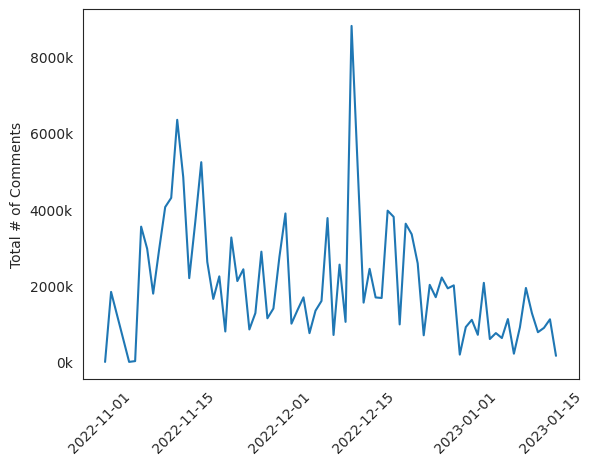

In [18]:
# Plot total views each day
plotLine(df_vid_stats_date, 'viewSum', ['2022-11-02', '2023-01-30'])

<Axes: ylabel='Total # of Comments'>

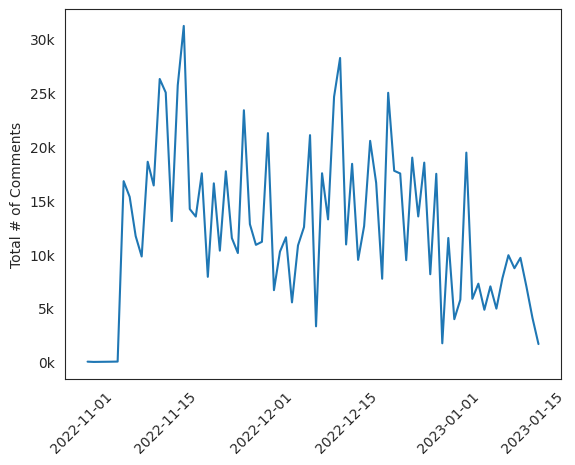

In [19]:
# Plot total comments each day
plotLine(df_vid_stats_date, 'commentSum', ['2022-11-02', '2023-01-30'])

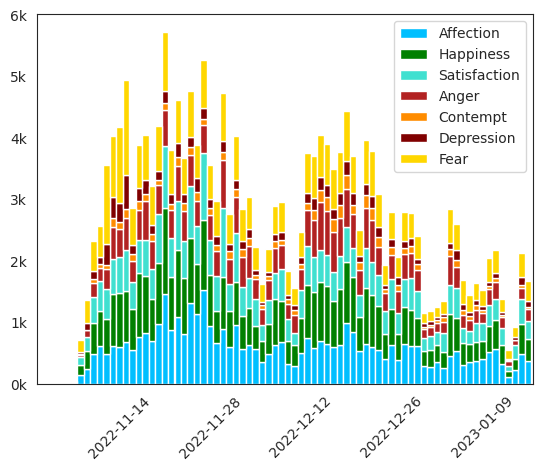

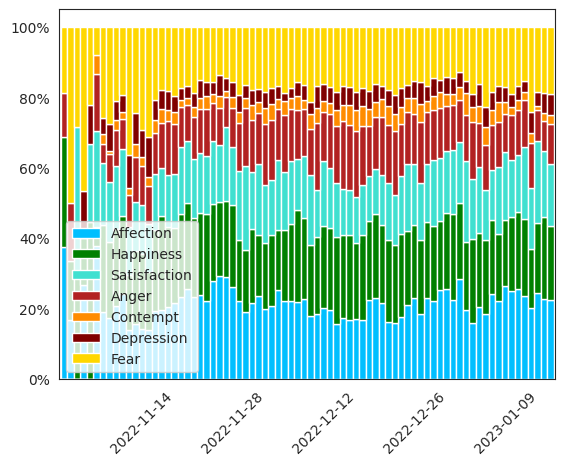

In [20]:
# Summarise comment emotions
df_comments_emotion, df_comments_emotion100 = plotStack(df_comments, ['2022-11-01', '2023-01-30'])

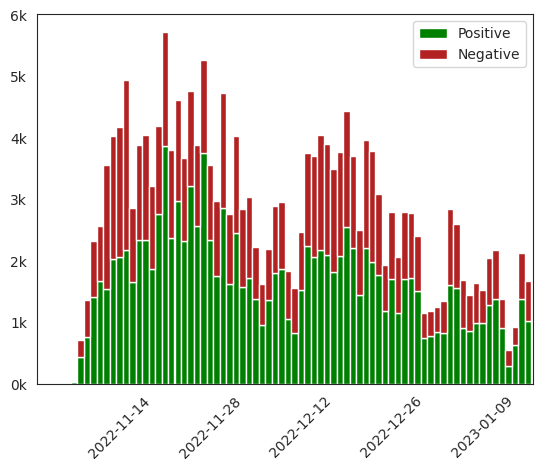

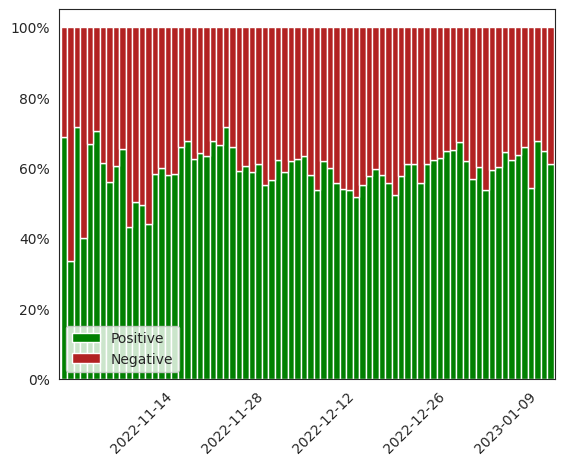

In [21]:
# Summarise comment valence
df_comments_valence, df_comments_valence100 = plotStack(df_comments, ['2022-11-01', '2023-01-30'], valence=True)

<ipython-input-22-ae05a99738f9>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



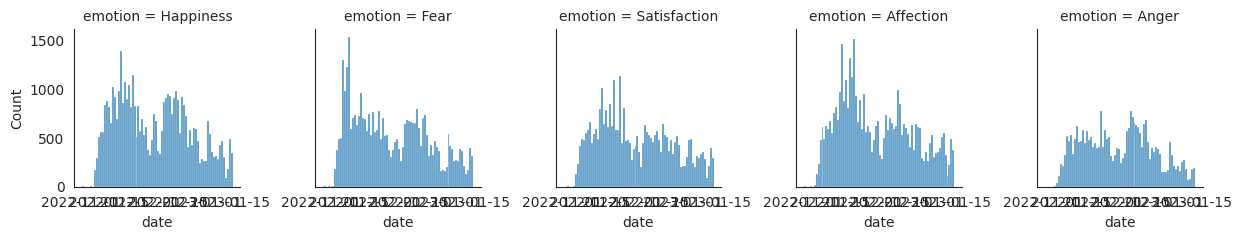

In [22]:
df_comments_emoclean = df_comments[~df_comments["emotion"].isin(["Neutral", "error"])]
g = sns.FacetGrid(df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Happiness", "Fear", "Satisfaction", "Anger"])],
                  col="emotion", height=2.5
                  )
g.map_dataframe(sns.histplot, x="date")

<ipython-input-23-5fa212ce04a7>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



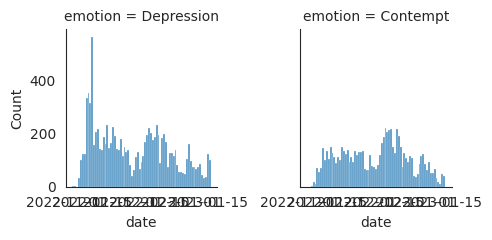

In [23]:
g = sns.FacetGrid(df_comments_emoclean[df_comments["emotion"].isin(["Contempt", "Depression"])],
                  col="emotion", height=2.5
                  )
g.map_dataframe(sns.histplot, x="date")

<ipython-input-24-cab2fe2d674e>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



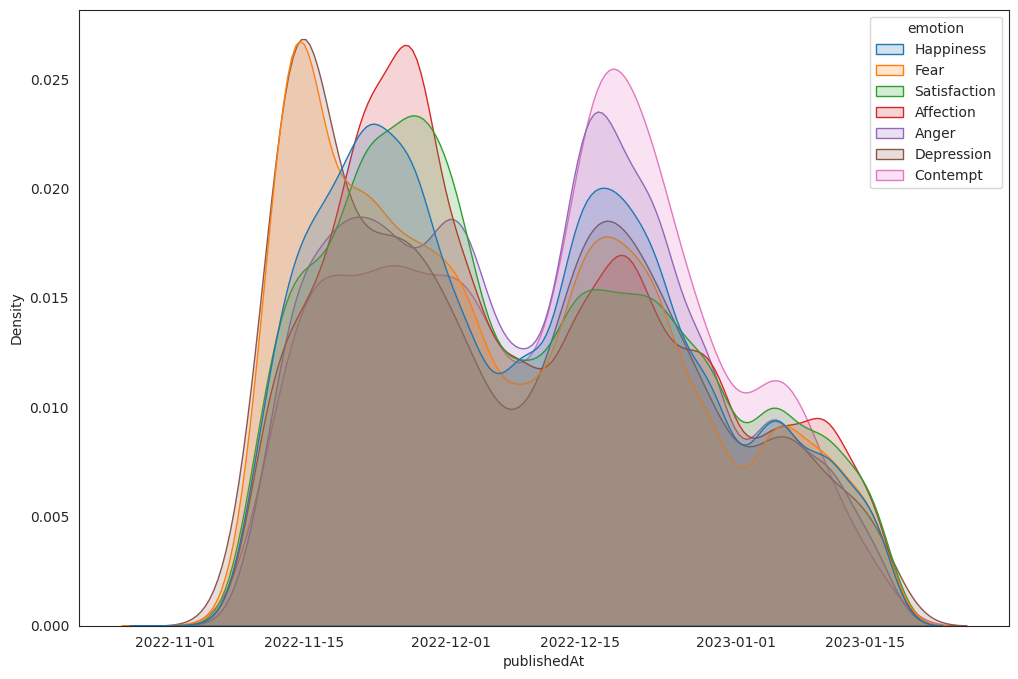

In [24]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# With transparency
sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Anger", "Happiness", "Fear", "Satisfaction", "Contempt", "Depression"])],
            x="publishedAt", hue="emotion",
            fill=True, common_norm=False, alpha=0.2)
plt.show()

<ipython-input-25-a53681973f0c>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



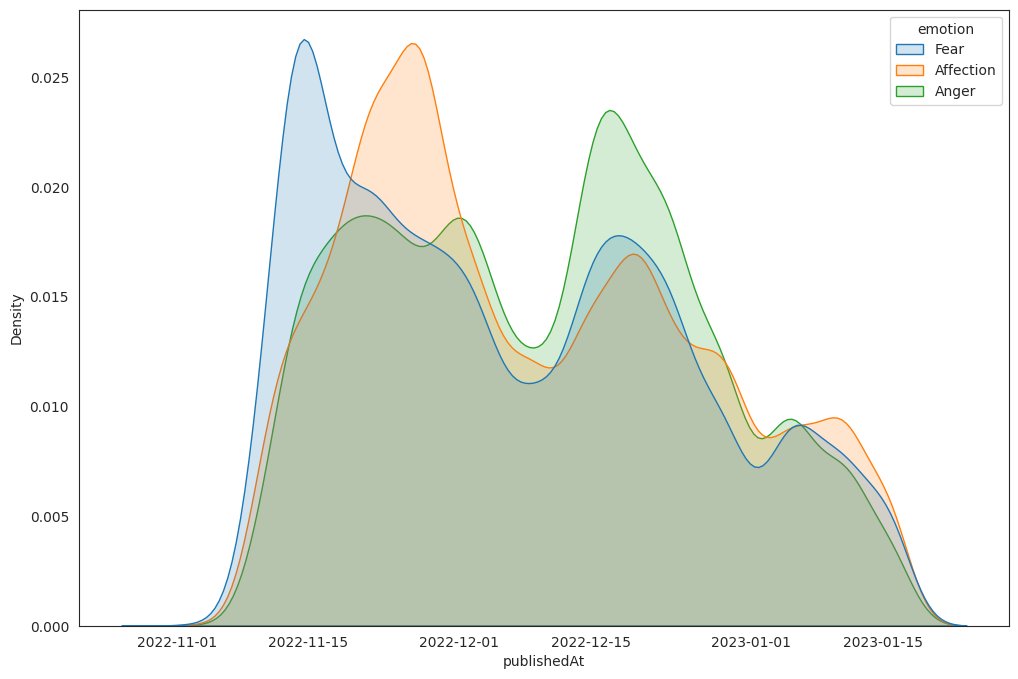

In [25]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# With transparency
sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Anger", "Fear"])],
            x="publishedAt", hue="emotion",
            fill=True, common_norm=False, alpha=0.2)
plt.show()

---
# 4. Dataset & Function Creation

## 4.1. Dataset Creation

In [26]:
df_affection    = df_comments_emoclean[df_comments_emoclean['emotion']=="Affection"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_anger        = df_comments_emoclean[df_comments_emoclean['emotion']=="Anger"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_contempt     = df_comments_emoclean[df_comments_emoclean['emotion']=="Contempt"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_depression   = df_comments_emoclean[df_comments_emoclean['emotion']=="Depression"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_fear         = df_comments_emoclean[df_comments_emoclean['emotion']=="Fear"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_happiness    = df_comments_emoclean[df_comments_emoclean['emotion']=="Happiness"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_satisfaction = df_comments_emoclean[df_comments_emoclean['emotion']=="Satisfaction"].groupby('date').agg(count=('commentid', 'count')).reset_index()

<ipython-input-27-b25f469c46cf>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



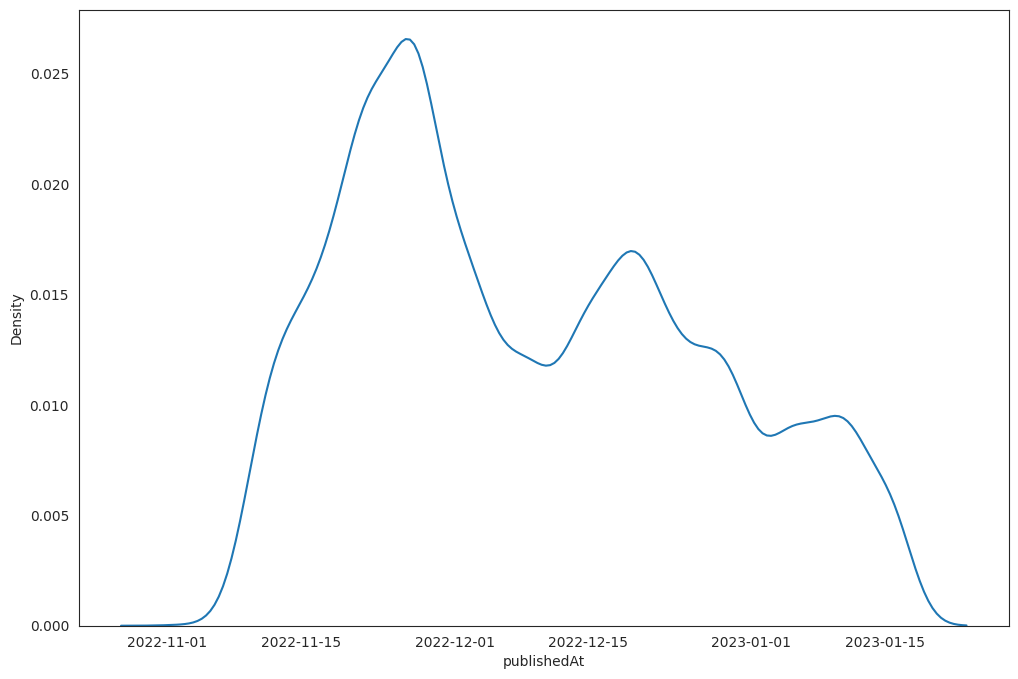

In [27]:
my_kde = sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"]=="Affection"], x="publishedAt")
line = my_kde.lines[0]
x, y = line.get_data()

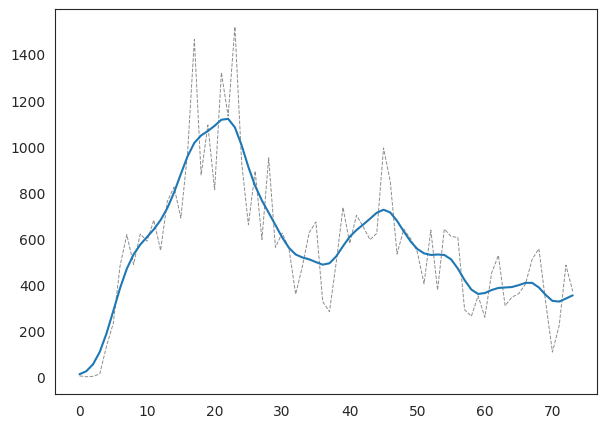

In [28]:
from scipy.ndimage import gaussian_filter1d
y_pos = np.arange(len(df_affection['date']))
Final_array_smooth = gaussian_filter1d(df_affection['count'], sigma=2)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(y_pos, df_affection['count'], '--', linewidth=0.7, color='k', alpha=0.45)
ax.plot(y_pos, Final_array_smooth)

In [29]:
def slope(x1, y1, x2, y2):
    m = np.log(y2/y1)/(x2-x1)
    return m

## 4.2. Estimating Parameters

### 4.2.1. Estimating μ

Mu = 0.0885609651151556 and duration of infection is 11.291656529484548 days


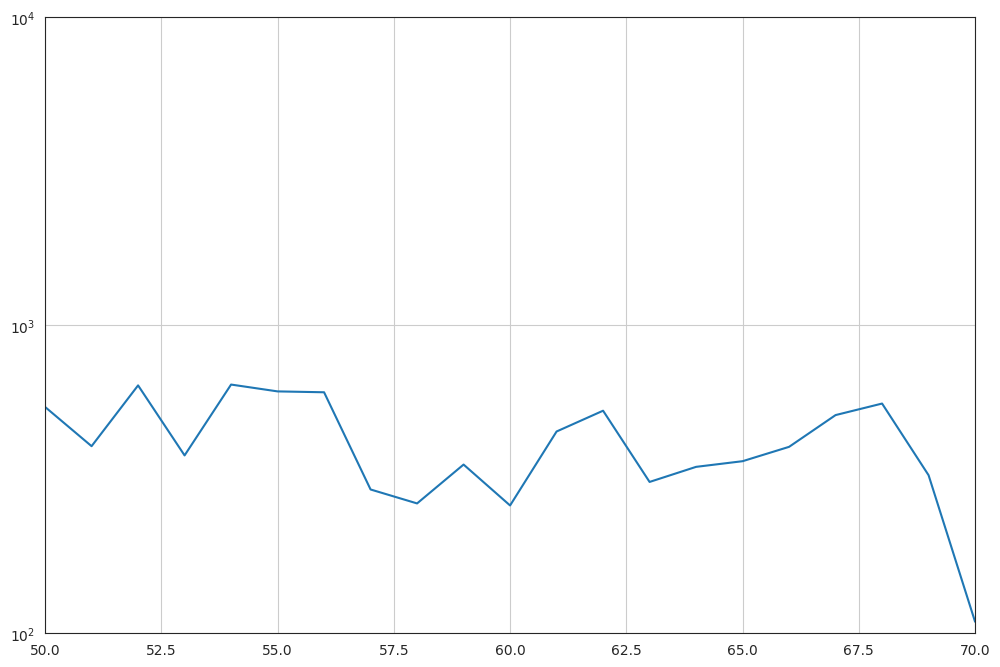

In [30]:
plt.plot(df_affection.index, df_affection['count'])

plt.yscale('log')
plt.ylim([10E1, 10E3])
plt.xlim([50, 70])
plt.grid()

mu_affection = -1 * slope(55, 10.0**3, 68, 10.0**2.5)
print(f"Mu = {mu_affection} and duration of infection is {1/mu_affection} days")

### 4.2.2. Estimating Nγ

Beta = 0.02708923638816527


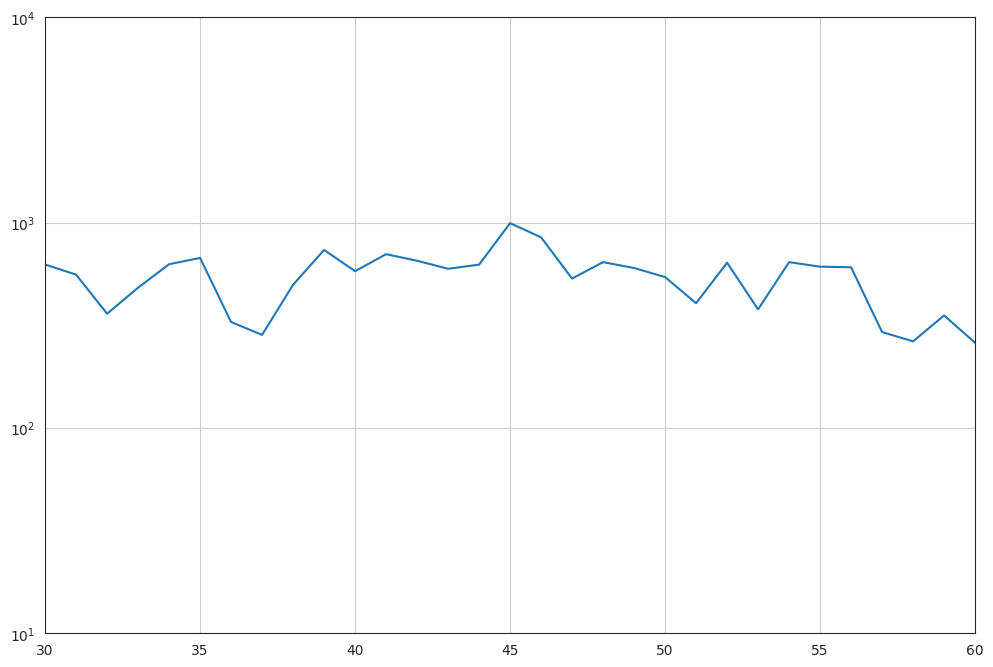

In [31]:
plt.plot(df_affection.index, df_affection['count'])

plt.yscale('log')
plt.ylim([10E0, 10E3])
plt.xlim([30, 60])
plt.grid()

beta_affection = slope(37, 10.0**2.9, 54, 10.0**3.1)
print(f"Beta = {beta_affection}")

### 4.2.3. Estimating $R_0$ and $S_0$

In [32]:
# R0
R0 = beta_affection / mu_affection
print(f"R0 = {R0}")

# S0
I_max = df_affection['count'].max()
S0 = I_max / (1 - (1 + np.log(R0))/ R0)
print(f"S0 = {S0}")

R0 = 0.30588235294117677
S0 = 947.3902386330984


---
# 5. SIR Model

In [34]:
SIR_model = '''
  // Equations
  E1: S1 -> I1 ; b * I1 * S1 ;
  E2: I1 -> R1 ; k1 * I1 ;

  // Parameters
  b = 2 ;
  k1 = 0.5 ;

 // Initial Conditions
  S1 = 1 ;
  I1 = 0.00001 ;
  R1 = 0.0 ;
'''

## 5.1. Affection

In [35]:
df_model = df_affection

In [36]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=2500, min=S0/10000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.8e-04, min=0, max=1)
params.add("k1", value=0.08, min=0, max=1)

In [37]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

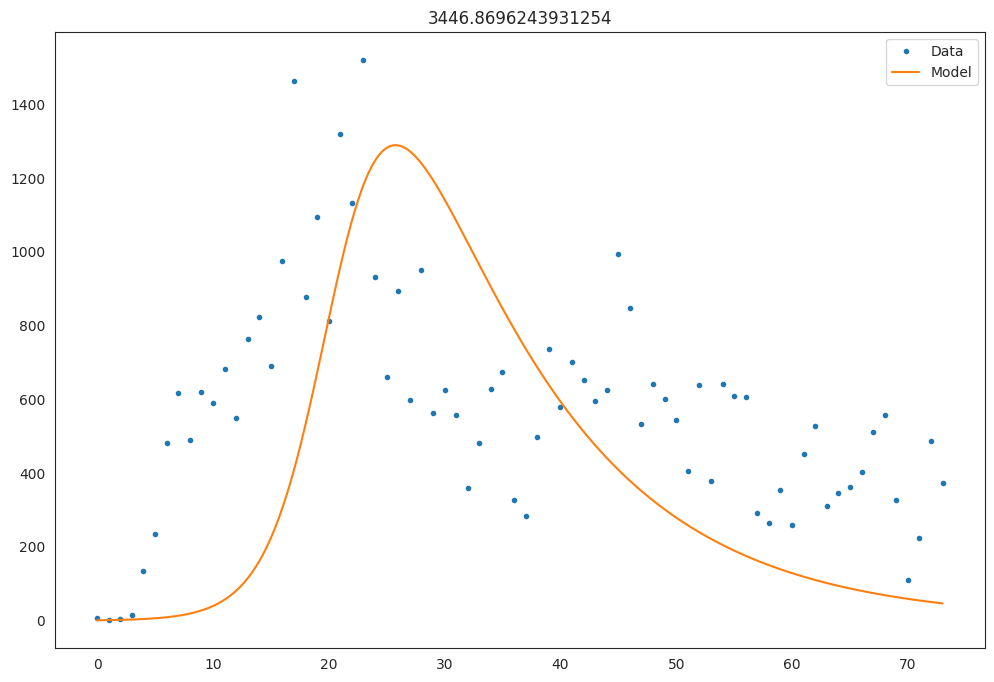

3446.8696243931254

In [38]:
cost_fun(params, plot=True)

In [39]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 46.82 days
R0 = 16.39


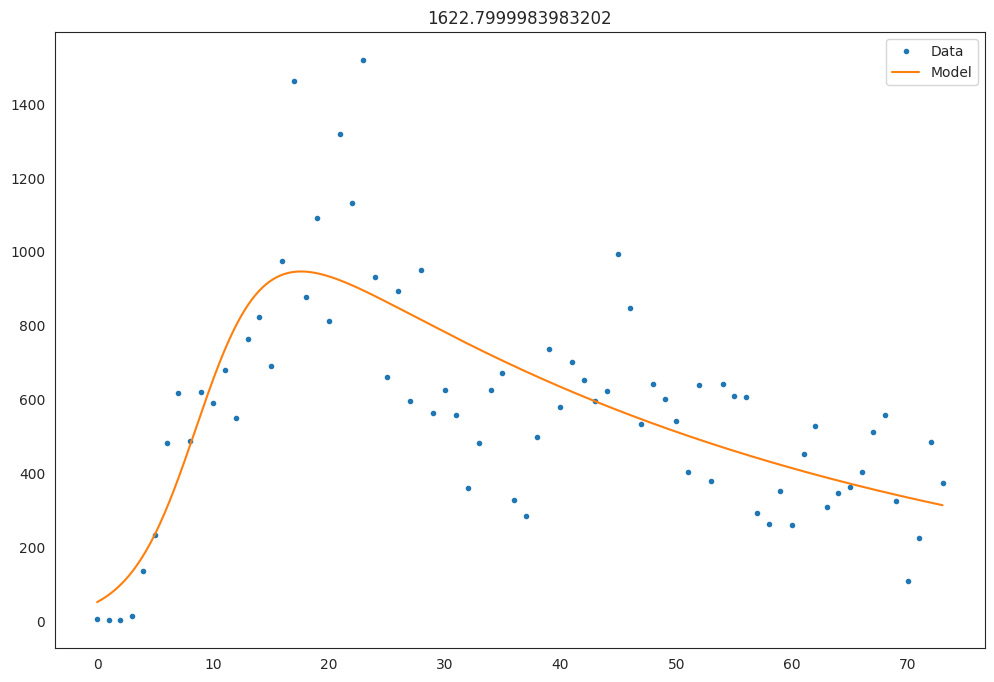

1622.7999983983202

In [40]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=I1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)

## 5.2. Anger

In [41]:
df_model = df_anger

In [42]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=1900, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.27e-04, min=0, max=1)
params.add("k1", value=0.077, min=0, max=1)

In [43]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

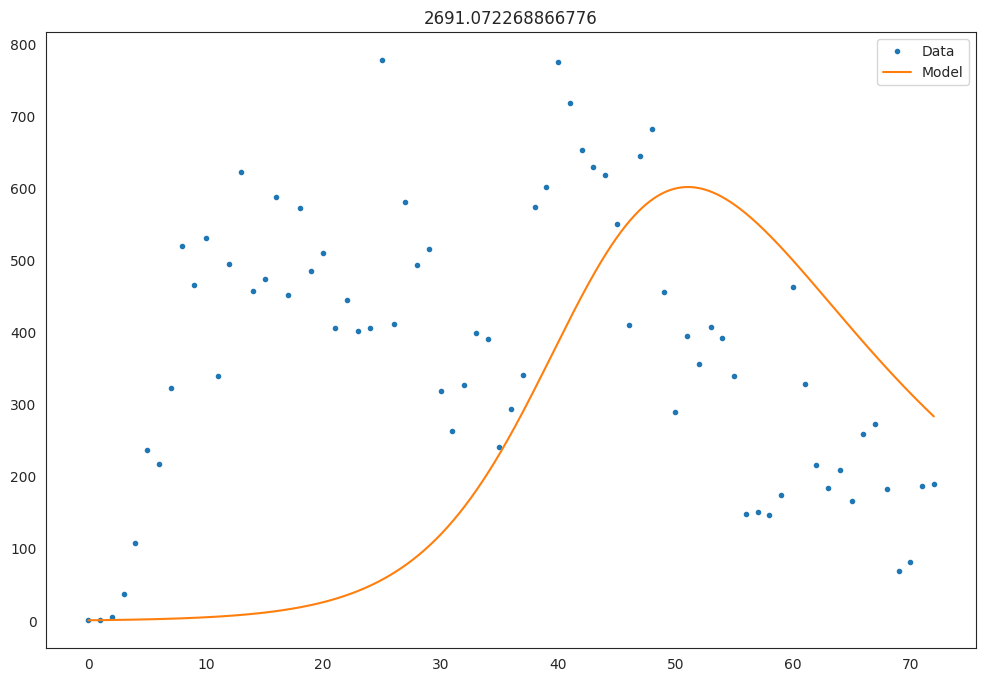

2691.072268866776

In [44]:
cost_fun(params, plot=True)

In [45]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 75.75 days
R0 = 36.89


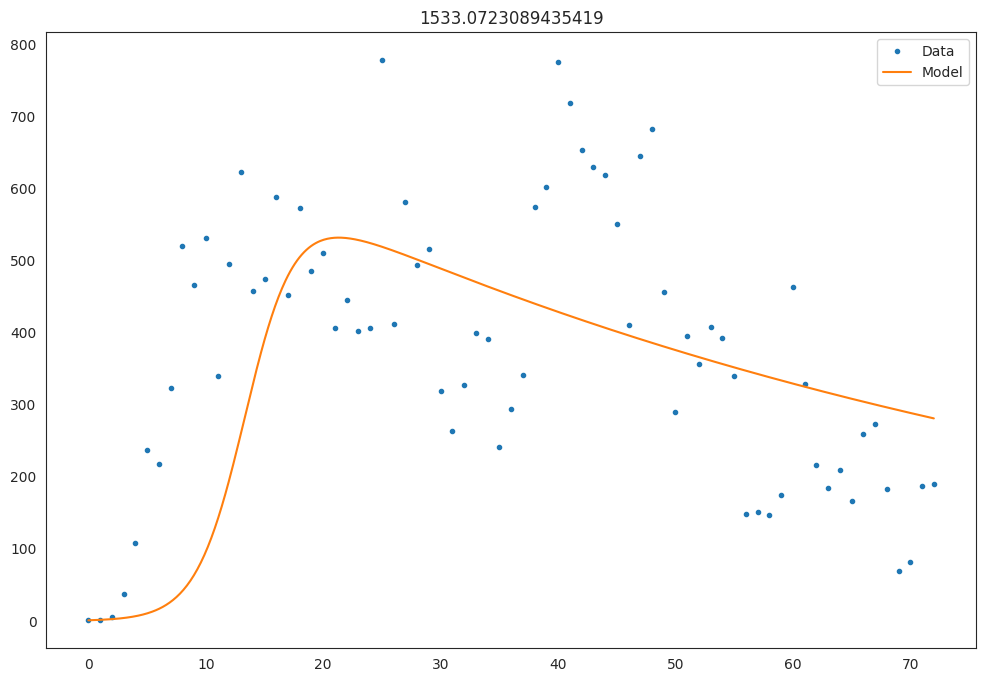

1533.0723089435419

In [46]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)
cost_fun(params, plot=True)

## 5.3. Contempt

In [47]:
df_model = df_contempt

In [48]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=1900, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.27e-04, min=0, max=1)
params.add("k1", value=0.077, min=0, max=1)

In [49]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

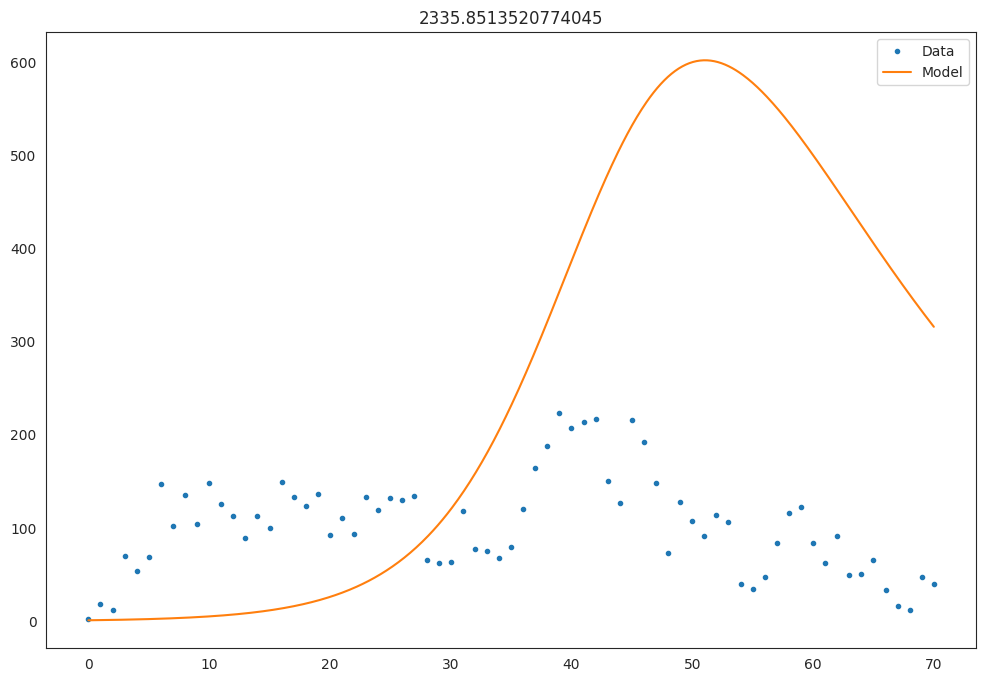

2335.8513520774045

In [50]:
cost_fun(params, plot=True)

In [51]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 81.98 days
R0 = 55.69


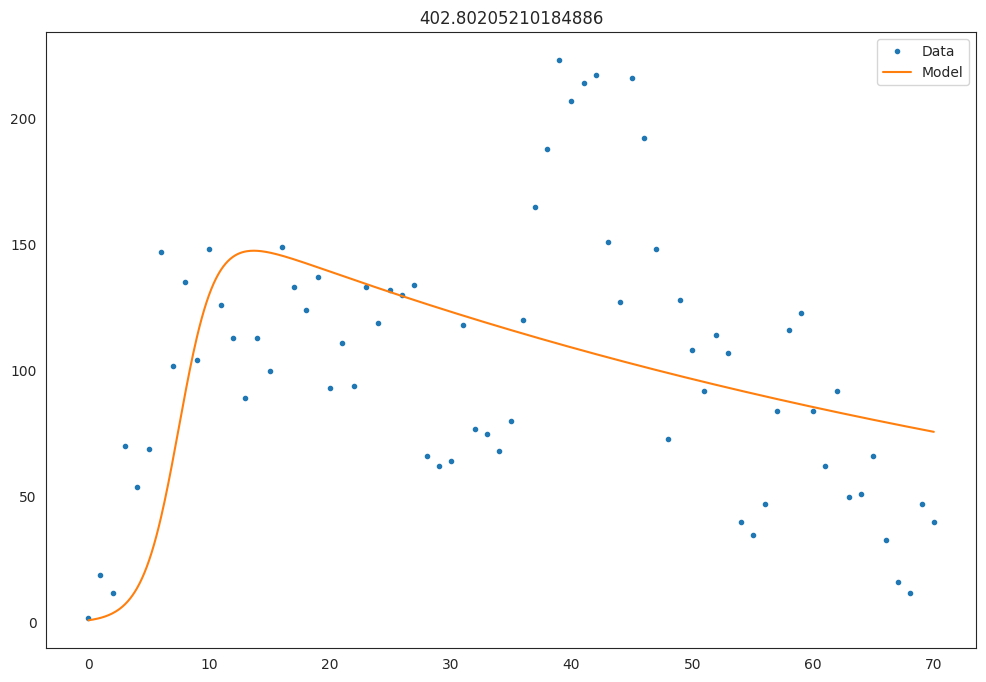

402.80205210184886

In [52]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)

## 5.4. Fear

In [53]:
df_model = df_fear

In [54]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=3000, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=8.4838e-05, min=0, max=1)
params.add("k1", value=0.05174697, min=0, max=1)

In [55]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

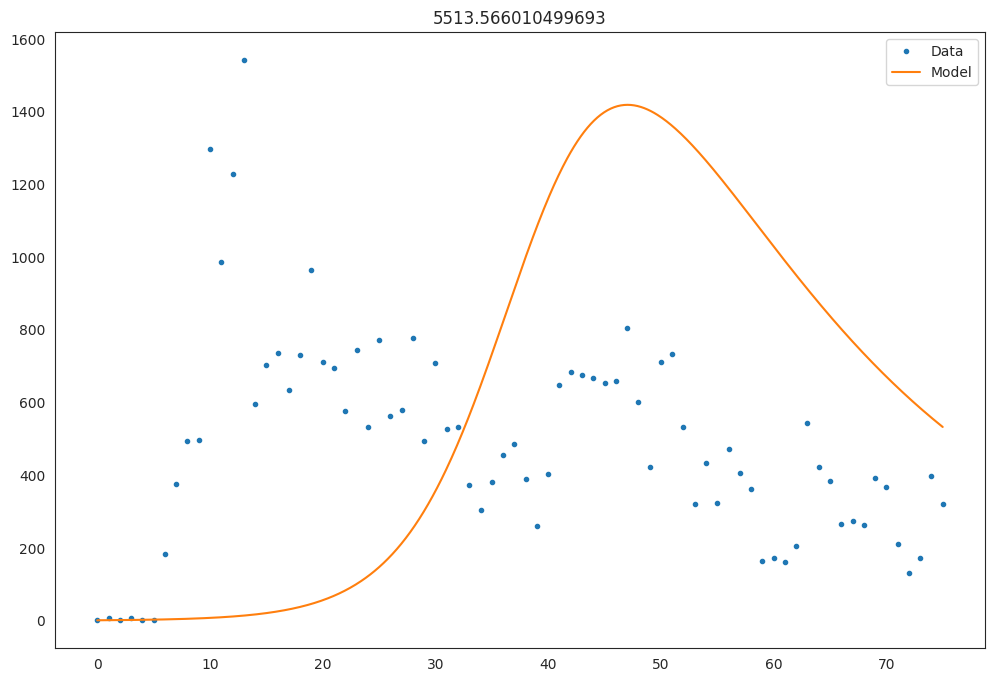

5513.566010499693

In [56]:
cost_fun(params, plot=True)

In [57]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 50.38 days
R0 = 46.85


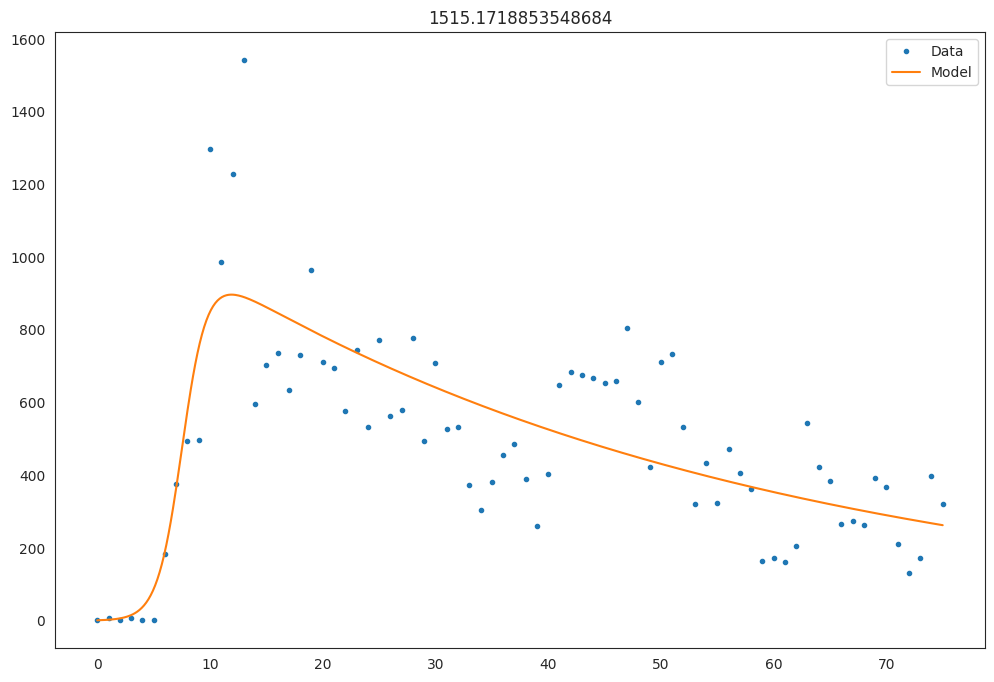

1515.1718853548684

In [58]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=I1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)

## 5.5. Depression

In [59]:
df_model = df_depression

In [60]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=500, min=S0/10000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.1423e-03, min=0, max=1)
params.add("k1", value=0.082625718	, min=0, max=1)

In [61]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

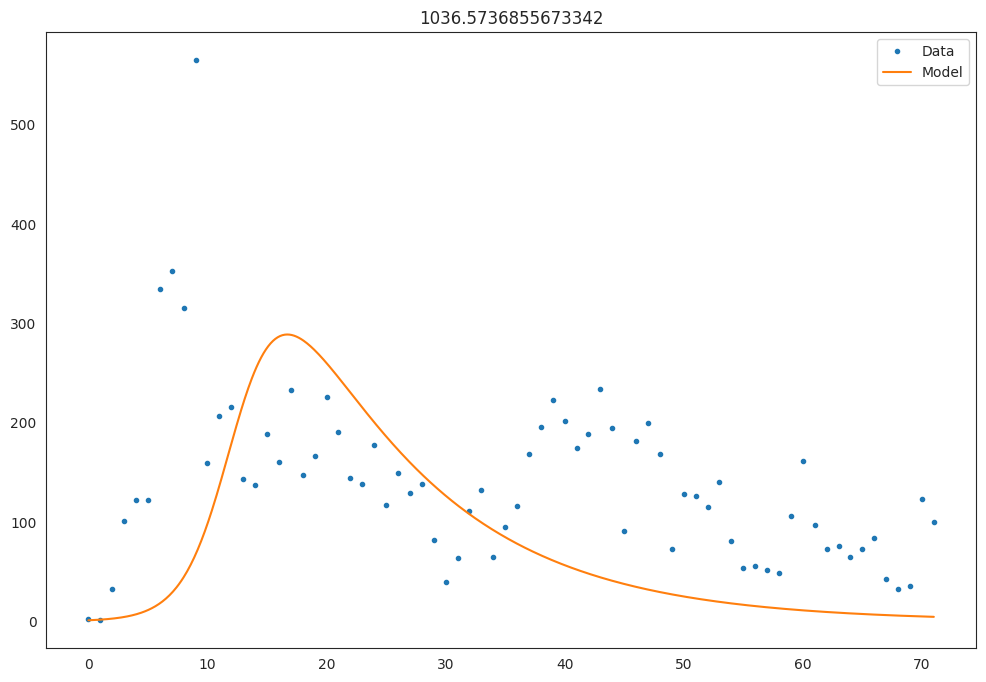

1036.5736855673342

In [62]:
cost_fun(params, plot=True)

In [63]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 47.92 days
R0 = 63.17


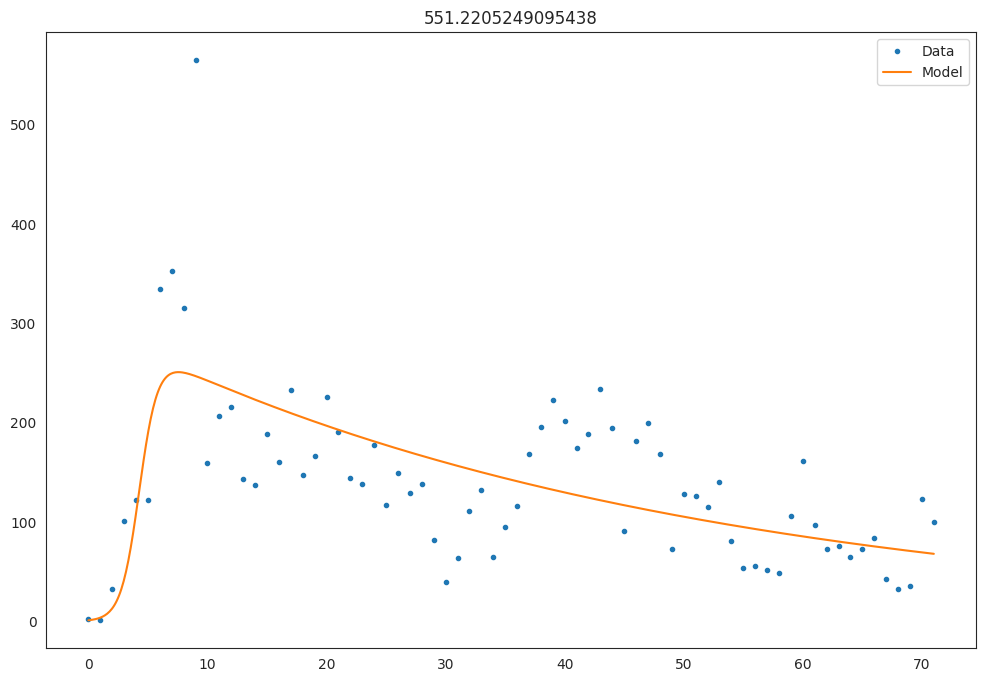

551.2205249095438

In [64]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)

## 5.6. Happiness

In [65]:
df_model = df_happiness

In [66]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=2500, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.8e-04, min=0, max=1)
params.add("k1", value=0.08, min=0, max=1)

In [67]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

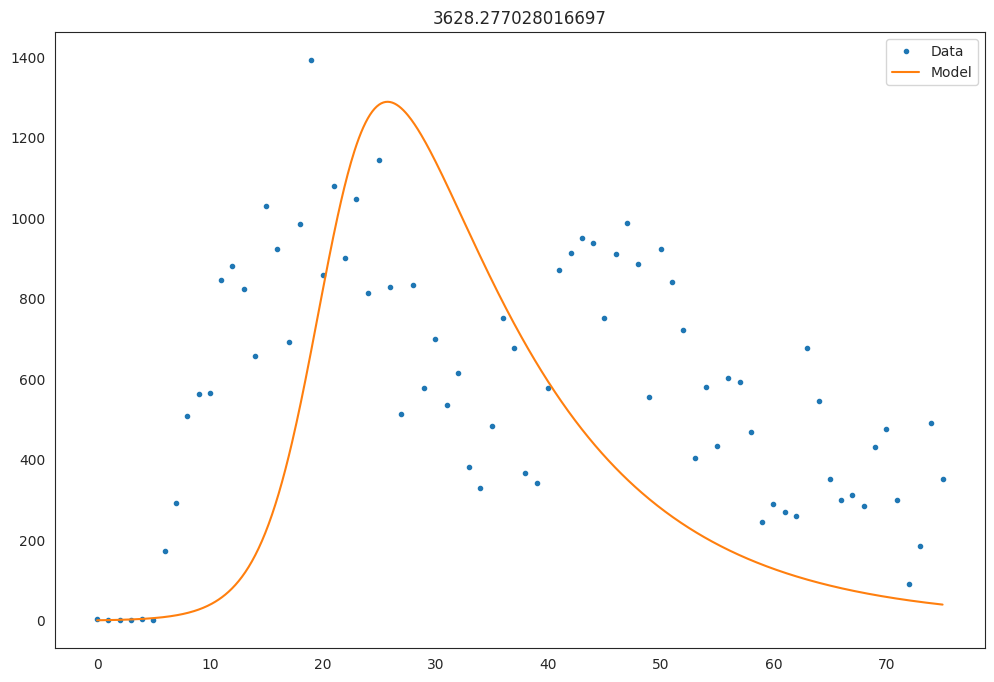

3628.277028016697

In [68]:
cost_fun(params, plot=True)

In [69]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 61.26 days
R0 = 32.97


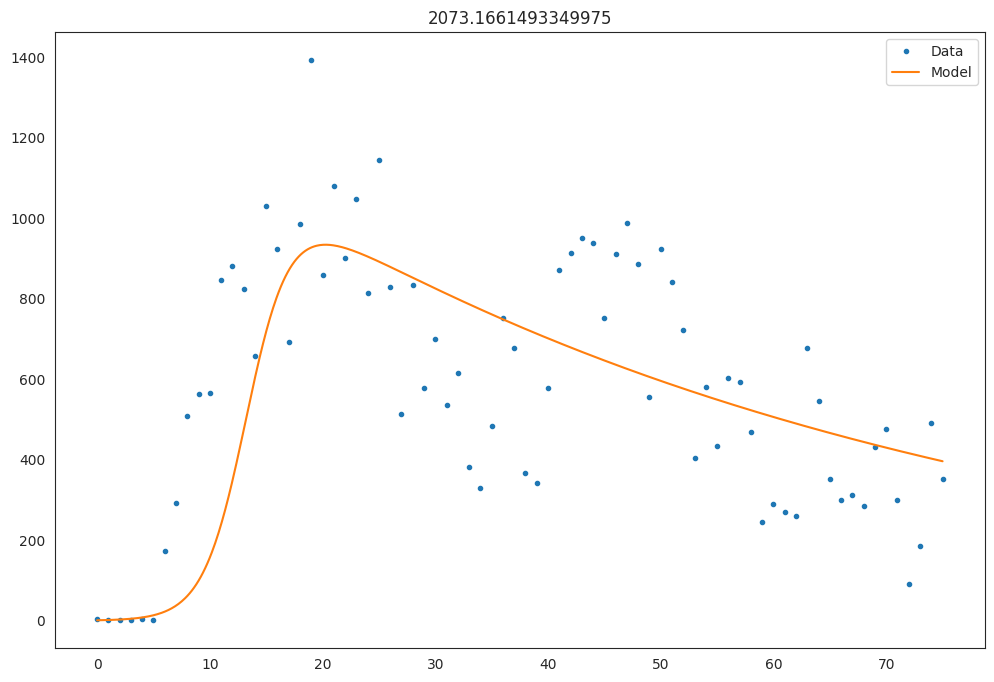

2073.1661493349975

In [70]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)

## 5.7. Satisfaction

In [71]:
df_model = df_satisfaction

In [72]:
# Parameters
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=2500, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=1.8e-04, min=0, max=1)
params.add("k1", value=0.08, min=0, max=1)

In [73]:
# Define Objective Function
def cost_fun(
    p,                                # Parameters
    model = SIR_model,                # Model Definition
    toFit = toFit,                    # Parameter Names
    T = df_model.index,               # Time Dimension
    activeCases = df_model['count'],  # Counts of Infected
    plot: bool = False
    ):

  # Load model definition
  m = te.loada(model)

  # Load parameters
  pp = p.valuesdict()

  # Loop through parameters to get values
  nParameters = len(toFit)
  for i in range(nParameters):
    m.model[toFit[i]] = pp[toFit[i]]

  # Simulation
  try:
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])
    diff = 0
    for i in range(len(T)):
      j = (np.abs(s['time'] - T[i])).argmin()
      diff += (activeCases[i] - s['I1'][j]) ** 2
    diff = np.sqrt(diff)

    # Plot
    if plot:
      plt.plot(T, activeCases, '.', label='Data')
      plt.plot(s['time'], s['I1'], label='Model')
      plt.legend()
      plt.title(str(diff))
      plt.show()

  except RuntimeError:
    diff = 1E21

  return diff

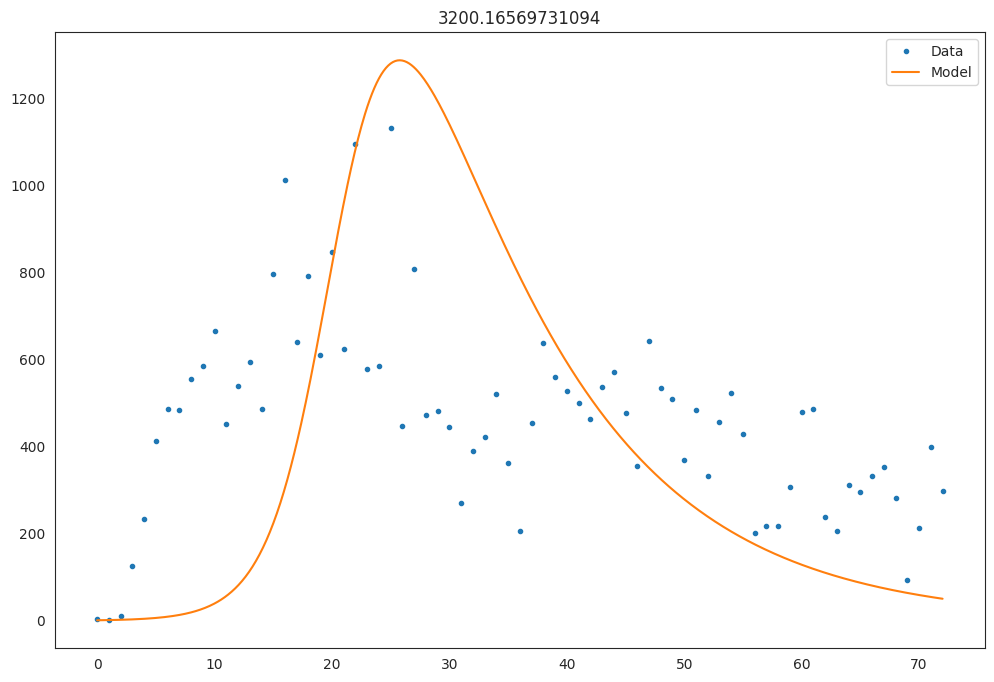

3200.16569731094

In [74]:
cost_fun(params, plot=True)

In [75]:
minimizer = lmfit.Minimizer(cost_fun, params, max_nfev=1000)
result = minimizer.minimize(method='nelder')
#lmfit.report_fit(result.params, min_correl=0.5)
result

Duration of the infection = 54.45 days
R0 = 18.80


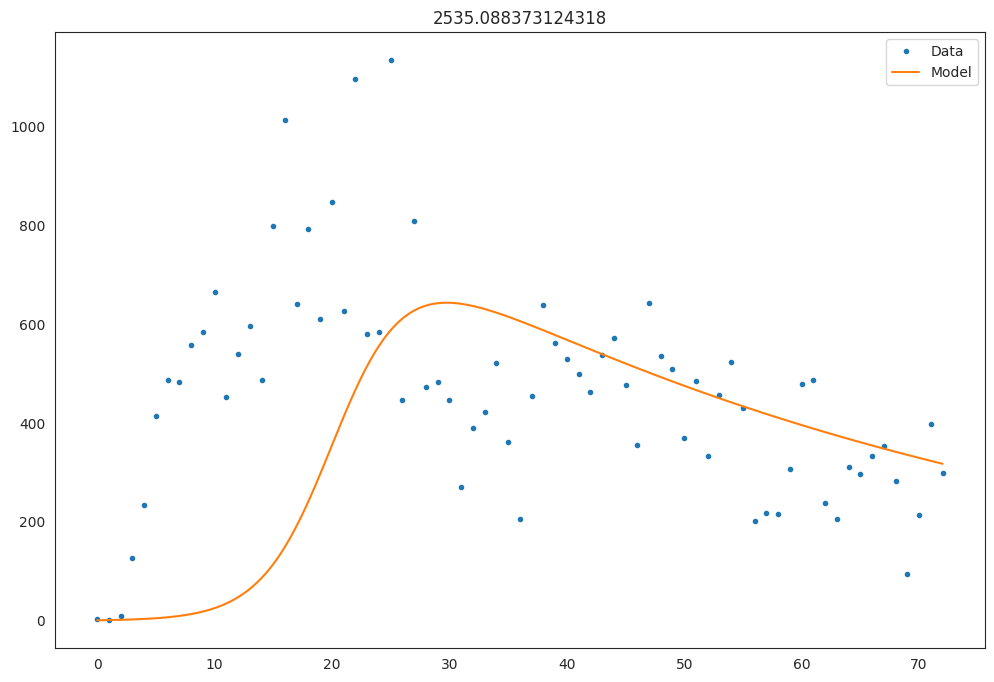

2535.088373124318

In [76]:
k1 = result.params['k1'].value
b = result.params['b'].value
I1 = result.params['I1'].value
S1 = result.params['S1'].value
print("Duration of the infection = %.2f days" % (1.0/k1))
print("R0 = %.2f" % (b * S1/k1))

# Parameters
toFit = ["S1", "I1", 'b', 'k1']
params = lmfit.Parameters()
params.add("S1", value=S1, min=S0/1000000, max=S0)
params.add("I1", value=1, min=1, max=S0/1000000)
params.add("b", value=b, min=0, max=1)
params.add("k1", value=k1, min=0, max=1)

cost_fun(params, plot=True)